# Pretrained models and resources

- https://www.tensorflow.org/api_docs/python/tf/keras/applications

- https://www.tensorflow.org/hub


# Tensorflow JS

- https://www.tensorflow.org/js/demos


# Observe how we use a model from TFHub to obtain image features

we will use this model:

https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4

In [26]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    %load_ext tensorboard
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io
import numpy as np
from skimage.transform import resize
import os
from progressbar import progressbar as pbar
import tensorflow_hub as hub
tf.__version__

setting tensorflow version in colab
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'2.1.0'

## Get the images from Kaggle!!!

In [27]:
!wget -nc https://rlx.s3.amazonaws.com/cactus-aerial-photos.zip

File ‘cactus-aerial-photos.zip’ already there; not retrieving.



In [14]:
!unzip cactus-aerial-photos.zip > /dev/null

replace training_set/training_set/cactus/cactus_0028_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Resize images to that required from by the model

In [0]:

def getimgs(setpart, classname, max_imgs=1500):
  imgs_names   = os.listdir("%s_set/%s_set/%s"%(setpart, setpart, classname))
  imgs = np.zeros( (max_imgs, 160, 160, 3)).astype(np.float32)
  for i,img_name in enumerate(pbar(imgs_names[:max_imgs])):
    img = io.imread("%s_set/%s_set/%s/%s"%(setpart, setpart, classname, img_name))
    rimg = resize(img, (160,160))
    imgs[i] = rimg
  print ("check min max of image pixels", imgs.min(), imgs.max())
  return imgs



In [78]:
train_cactus   = getimgs("training", "cactus")
train_nocactus = getimgs("training", "no_cactus")
val_cactus   = getimgs("validation", "cactus")
val_nocactus = getimgs("validation", "no_cactus")


100% (1500 of 1500) |####################| Elapsed Time: 0:00:09 Time:  0:00:09


check min max of image pixels 0.0 1.0


100% (1500 of 1500) |####################| Elapsed Time: 0:00:10 Time:  0:00:10


check min max of image pixels 0.0 1.0


100% (1500 of 1500) |####################| Elapsed Time: 0:00:10 Time:  0:00:10


check min max of image pixels 0.0 1.0


100% (1000 of 1000) |####################| Elapsed Time: 0:00:06 Time:  0:00:06


check min max of image pixels 0.0 1.0


In [79]:
train_cactus.shape, train_nocactus.shape, val_cactus.shape, val_nocactus.shape

((1500, 160, 160, 3),
 (1500, 160, 160, 3),
 (1500, 160, 160, 3),
 (1500, 160, 160, 3))

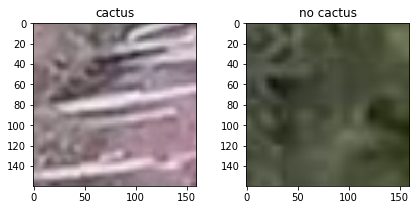

In [80]:
plt.figure(figsize=(7,3))
plt.subplot(121); plt.imshow(train_cactus[np.random.randint(len(train_cactus))]); plt.title("cactus")
plt.subplot(122); plt.imshow(train_nocactus[np.random.randint(len(train_nocactus))]); plt.title("no cactus");


## Obtain the model and apply it to the images

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [0]:
m = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4")
])
m.build([None, 160, 160, 3])  # Batch input shape.

In [0]:
ftrain_cactus = m(train_cactus).numpy()
ftrain_nocactus = m(train_nocactus).numpy()
fval_cactus = m(val_cactus).numpy()
fval_nocactus = m(val_nocactus).numpy()


In [50]:
ftrain_cactus.shape, ftrain_nocactus.shape, fval_cactus.shape, fval_nocactus.shape

((1500, 1001), (1500, 1001), (1500, 1001), (1500, 1001))

In [0]:
xtrain = np.vstack((ftrain_cactus, ftrain_nocactus))
xval   = np.vstack((fval_cactus, fval_nocactus))
ytrain = [1]*len(ftrain_cactus)+[0]*len(ftrain_nocactus)
yval   = [1]*len(fval_cactus)+[0]*len(fval_nocactus)


## Now use any classical method 

In [59]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(xtrain, ytrain)
print ("train score %.3f"%rf.score(xtrain, ytrain))
print ("test score  %.3f"%rf.score(xval, yval))

train score 1.000
test score  0.801
